In [13]:
!pip install scikit-learn

In [21]:
import sklearn
print(sklearn.__version__)

1.6.1


In [19]:
import sys
print(sys.executable)

C:\Users\Carlos\AppData\Local\Programs\Python\Python310\python.exe


In [20]:
import sys
!{sys.executable} -m pip install scikit-learn

You should consider upgrading via the 'C:\Users\Carlos\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import os

dataset_path = "dataset"

for categoria in ["piezas_buenas", "piezas_malas"]:
    ruta = os.path.join(dataset_path, categoria)
    archivos = os.listdir(ruta)
    print(f"{categoria}: {len(archivos)} imágenes")

piezas_buenas: 245 imágenes
piezas_malas: 92 imágenes


In [9]:
import os

import cv2
import numpy as np

# =============================================
# 1. Carga y preprocesamiento de imágenes
# =============================================

# Ruta a la carpeta dataset
DATASET_PATH = "dataset"
IMG_SIZE = 128

# Etiquetas: piezas buenas = 0, piezas malas = 1
CATEGORIES = ["piezas_buenas", "piezas_malas"]

data = []

# Recorremos ambas categorías
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # Leer la imagen en escala de grise(hemos cambiado a color porque tenemos fallos por manchas, quemaduras etc)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # 🎨 Convertir de BGR a RGB (OpenCV usa BGR por defecto)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Redimensionar a 128x128
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            # Normalizar valores (de 0-255 a 0-1)
            img = img / 255.0
            # Añadir a la lista de datos junto con su etiqueta (0 o 1)
            data.append([img, label])
        except Exception as e:
            print(f"⚠️ Error al procesar {img_path}: {e}")

# Mezclar los datos aleatoriamente
import random
random.shuffle(data)

# Separar datos y etiquetas
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convertir a arrays de numpy(3 es el numero de canales de color, si fuera escala de grises habria que poner 1)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

print("✅ Imágenes preprocesadas correctamente")
print("🔢 Tamaño de X:", X.shape)
print("🔢 Tamaño de y:", y.shape)

✅ Imágenes preprocesadas correctamente
🔢 Tamaño de X: (337, 128, 128, 3)
🔢 Tamaño de y: (337,)


✅ Dataset balanceado:
Total imágenes: {len(X_balanced)}
Buenas: {sum(y_balanced == 0)}
Malas: {sum(y_balanced == 1)}

[👀] Visualizando muestras aumentadas...


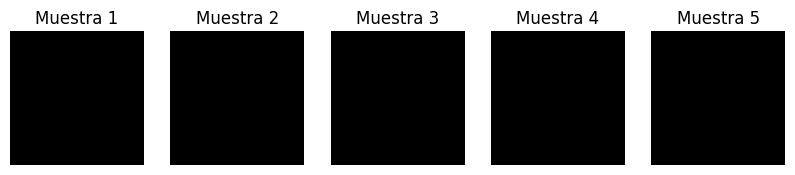

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# =============================================
# 2. Oversampling de la clase minoritaria
# =============================================

# Separa los datos por clase
X_buenas = X[y == 0]  # Clase 0: piezas buenas
X_malas = X[y == 1]   # Clase 1: piezas malas



# Configura el generador de aumentos solo para piezas malas
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Calcula cuántas muestras adicionales necesitas
muestras_necesarias = len(X_buenas) - len(X_malas)


# Generación de imágenes aumentadas (parte corregida)
X_malas_aumentadas = []
for i in range(len(X_buenas) - len(X_malas)):
    # Elige una imagen aleatoria para aumentar
    img = X_malas[np.random.randint(0, len(X_malas))]
    img = img.reshape((1,) + img.shape)  # Asegura 4 dimensiones
    # Aplica transformaciones
    transformed = next(datagen.flow(img, batch_size=1))[0]
    X_malas_aumentadas.append(transformed)

# Convertir cada imagen aumentada a 4D (agregar dimensión de batch)
X_malas_aumentadas_4d = [img[np.newaxis, ...] for img in X_malas_aumentadas]

# Combinación final-->Combina con el dataset original
X_malas_oversampled = np.concatenate([X_malas] + X_malas_aumentadas_4d)
y_malas_oversampled = np.ones(len(X_malas_oversampled))

# Dataset final balanceado
X_balanced = np.concatenate([X_buenas, X_malas_oversampled])
y_balanced = np.concatenate([np.zeros(len(X_buenas)), y_malas_oversampled])



# Mezcla los datos
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

print("✅ Dataset balanceado:")
print("Total imágenes: {len(X_balanced)}")
print("Buenas: {sum(y_balanced == 0)}")
print("Malas: {sum(y_balanced == 1)}")

# Guardar dataset balanceado
np.save('X_balanced.npy', X_balanced)
np.save('y_balanced.npy', y_balanced)



# =============================================
# 3. Visualización de imágenes aumentadas
# =============================================
# Validación visual -->Verifica que las imágenes generadas:  
#Conservan los defectos relevantes.No presentan artefactos extraños. Son visualmente realistas.
import matplotlib.pyplot as plt

print("\n[👀] Visualizando muestras aumentadas...")
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_malas_aumentadas[i])
    plt.title(f"Muestra {i+1}")
    plt.axis('off')
plt.show()

✅ Datos divididos:
📊 X_train: (269, 128, 128, 3)
📊 X_val: (68, 128, 128, 3)

[🔁] Entrenando modelo...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.7292 - loss: 6.4196 - val_accuracy: 0.7941 - val_loss: 0.3647
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.9419 - loss: 0.4554 - val_accuracy: 0.6912 - val_loss: 12.4217
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.9805 - loss: 0.2397 - val_accuracy: 0.6912 - val_loss: 24.3602
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.9588 - loss: 0.2451 - val_accuracy: 0.6912 - val_loss: 28.7386
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - accuracy: 0.9769 - loss: 0.4013 - val_accuracy: 0.6912 - val_loss: 33.4603
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.9809 - loss: 0.1298 - val_accuracy: 0.6912 - val_loss: 28.2732
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.9923 - loss: 0.1773 - val_accuracy: 0.6912 - val_loss: 32.

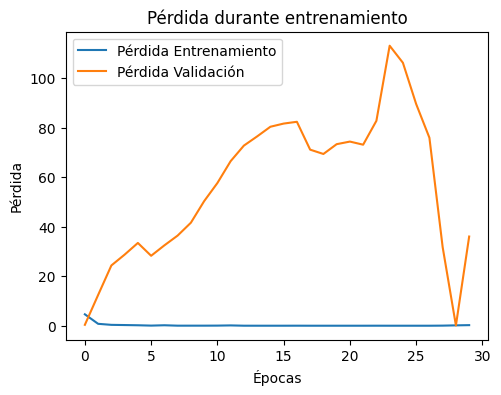

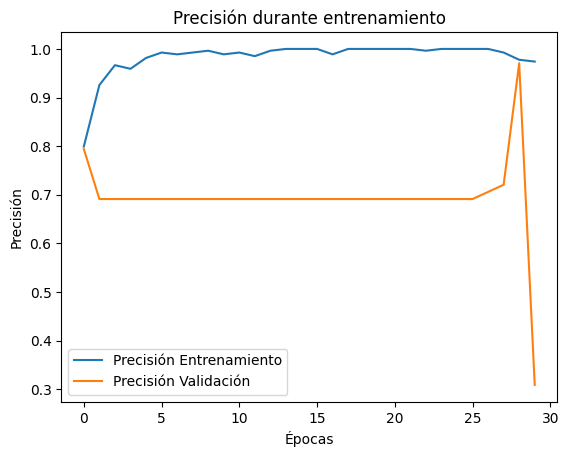

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# =============================================
# 4. División en train/validation
# =============================================

# 1️⃣ Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Datos divididos:")
print("📊 X_train:", X_train.shape)
print("📊 X_val:", X_val.shape)


# =============================================
# 5. Definición del modelo (tu arquitectura actual)
# =============================================

# 2️⃣ Crear el modelo CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.4),  # Subimos un poco para evitar sobreajuste
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Clasificación binaria
])


# 3️⃣ Compilar
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# =============================================
# 6. Entrenamiento con class_weight
# =============================================
# Pesos para compensar cualquier desbalance residual
class_weight = {0: 1, 1: 1.3}




# 4️⃣ Entrenar
print("\n[🔁] Entrenando modelo...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weight
)

'''#comentario triple comilla
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val)
)
'''

# =============================================
# 7. Evaluación y gráficas
# =============================================

# 5️⃣ Graficar resultados

#Gráfica de perdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title("Pérdida durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

#6 Gráfica de precision
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
# muestra que porcentaje de imagenes clasifico correctamente
# si la precision se mantiene alta en validación -> el modelo se generaliza bien


plt.title("Precisión durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()


In [47]:
model.save("mi_modelo.keras")

In [1]:
import os

# Ruta donde están tus imágenes
ruta =  "C:\\Users\\Carlos\\Desktop\\leather\\test\\poke"  # 👈 cambia esto si es necesario

# Listar los archivos PNG en orden
imagenes = sorted([f for f in os.listdir(ruta) if f.endswith(".png")])

# Desde qué número quieres empezar
contador = 74

for nombre in imagenes:
    nueva_ruta = os.path.join(ruta, f"{contador:03}.png")  # 3 dígitos: 019.png, 020.png, ...
    ruta_original = os.path.join(ruta, nombre)
    
    os.rename(ruta_original, nueva_ruta)
    print(f"✅ Renombrado: {nombre} → {contador:03}.png")
    
    contador += 1

✅ Renombrado: 000.png → 074.png
✅ Renombrado: 001.png → 075.png
✅ Renombrado: 002.png → 076.png
✅ Renombrado: 003.png → 077.png
✅ Renombrado: 004.png → 078.png
✅ Renombrado: 005.png → 079.png
✅ Renombrado: 006.png → 080.png
✅ Renombrado: 007.png → 081.png
✅ Renombrado: 008.png → 082.png
✅ Renombrado: 009.png → 083.png
✅ Renombrado: 010.png → 084.png
✅ Renombrado: 011.png → 085.png
✅ Renombrado: 012.png → 086.png
✅ Renombrado: 013.png → 087.png
✅ Renombrado: 014.png → 088.png
✅ Renombrado: 015.png → 089.png
✅ Renombrado: 016.png → 090.png
✅ Renombrado: 017.png → 091.png
